## Chinook database SQL queries

In this project we will be using SQL to show proficiency making queries to answer business questions from the Chinook record database `chinook.db` as well as doing some data visualization.The shcema for the `chinook.db` can be found __[here](https://images.app.goo.gl/hv1QTfERZY18LWtS8)__.

Our first task is to determine which three albums to purchase to add to the store. The four albums are by artists that we don't have any tracks for in the store right now. We are given the artists names and genre of music they produce:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline
import sqlite3

d = {'Artist Name': ['Regal', 'Red Tone', 'Meteor and the Girls', 'Slim Jim Bites'],
    'Genre': ['Hip-Hop', 'Punk', 'Pop', 'Blues']}
album_choices = pd.DataFrame(data = d)
album_choices

,Artist Name,Genre
0,Regal,Hip-Hop
1,Red Tone,Punk
2,Meteor and the Girls,Pop
3,Slim Jim Bites,Blues


We will start by creating some helper function in python to save time. We will also use a context manager to handle the connection to the SQLite database for safety and ease.

In [2]:
# defining a few functions to make work easier
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)

#running show_tables function
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Album Genres to recommend

Since we do not currently have any tracks by these artists our best source of information comes from knowing the genre. Our client has given Chinook money to advertise the new albums in the USA, therefore we will look at which albums sell the best by genre in the USA.

In [3]:
#get genre sales for 4 genres with USA customers
#first get tracks sold in USA

albums_recommend = '''
WITH tracks_sold_usa AS
    (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
    )
    
SELECT 
    g.name genre,
    count(tsu.invoice_line_id) tracks_sold,
    cast(count(tsu.invoice_line_id) AS FLOAT)*100/(SELECT
    COUNT (*) from tracks_sold_usa) percentage_sold
FROM tracks_sold_usa tsu   
INNER JOIN track t ON tsu.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

#ran query with more genres but no significant info. and 10 better for graph
run_query(albums_recommend)    

,genre,tracks_sold,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


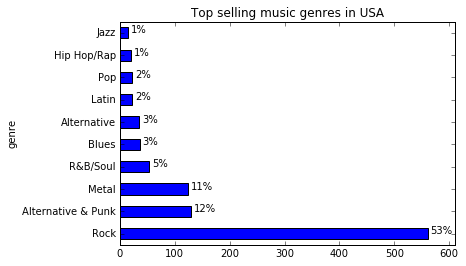

In [4]:
genre_sales_usa = run_query(albums_recommend)
genre_sales_usa.set_index('genre', drop = True, inplace = True)

genre_sales_usa['tracks_sold'].plot.barh(
    title = "Top selling music genres in USA",
    xlim = (0, 610),
    color = 'blue'
    )

for i, label in enumerate(genre_sales_usa.index):
        tracks = genre_sales_usa.loc[label, "tracks_sold"]
        label = (genre_sales_usa.loc[label, "percentage_sold"] 
                ).astype(int).astype(str) + "%"
        plt.annotate(label, (tracks + 5, i))
        
plt.show()        

Based on the track sales across different genres in the USA, we should purchase: 
-  Red Tone(Punk)
-  Slim Jim Bites(Blues)
-  Meteor and the Girls(Pop)

However, it should be noted that we should be on the lookout for artists and albums in the `Rock` genre as they make up over half (53%) of sales. The three genres we are currently purchasing from account for only about 17% of sales ___combined___.

## Analyzing Sales Agent Performance

Our next task is to analyze a select group of sales agent performances. Each customer is assigned to a sales support agent within the company when they first make a purchase. We will be looking at the purchases of customers belonging to each employee and assessing relative performance.

In [5]:
#first get total $ sales by each sales agent

sales_agent_performance = '''
WITH sales_agent_sales AS
    (
    SELECT 
        i.customer_id,
        c.support_rep_id,
        sum(i.total) total
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1, 2
    )
    
SELECT 
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(sas.total) total_sales
FROM sales_agent_sales sas
INNER JOIN employee e ON e.employee_id = sas.support_rep_id
GROUP BY 1;
'''

run_query(sales_agent_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


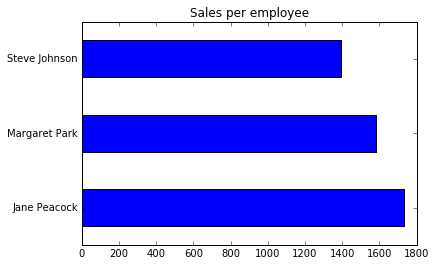

In [6]:
employee_sales = run_query(sales_agent_performance)

employee_sales.set_index('employee', drop = True, inplace = True)

employee_sales['total_sales'].plot.barh(
    title = "Sales per employee",
    xlim = (0, 1800),
    color = 'blue'
    )

plt.ylabel('')
plt.show()

Although Jane (top sales) has more than 20% more sales than Steve (bottom sales), that could easily be accounted for by their respective hire dates. This assumes that Jane has not had an inordinate amount of time off of work.

## Analyzing Sales by Country

For this task we will be using the country that is listed in the `customers` table rather than the country from the billing address in the `invoice` table as  it will represent the country where the sales actually occurred more accurately. We will be finding the following data for each country:
- Total number of customers
- Total value of sales
- Average value of sales per customer
- Average order value

If a country only has 1 customer we will group them together in "Other" in our analysis.

In [7]:
sales_by_country = '''
WITH country_or_other AS
    (
    SELECT
        CASE
            WHEN (
                 SELECT count(*)
                 FROM customer
                 WHERE country = c.country
                 ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
         )

SELECT
    country,
    customers,
    total_sales,
    avg_order,
    avg_customer_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price * quantity) total_sales,
        ROUND(SUM(unit_price * quantity) / count(distinct invoice_id), 2) avg_order,
        ROUND(SUM(unit_price * quantity) / count(distinct customer_id), 2) avg_customer_value,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
        );
'''

run_query(sales_by_country)   

,country,customers,total_sales,avg_order,avg_customer_value
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,Czech Republic,2,273.24,9.11,136.62
6,United Kingdom,3,245.52,8.77,81.84
7,Portugal,2,185.13,6.38,92.57
8,India,2,183.15,8.72,91.58
9,Other,15,1094.94,7.45,73.00


## Visualizing Sales by Country

The above table provides some good information for our sales by country. However, visualization can lead us to a better understanding of the data. Below we will create a few different visualizations in order to better understand what the above information represents.

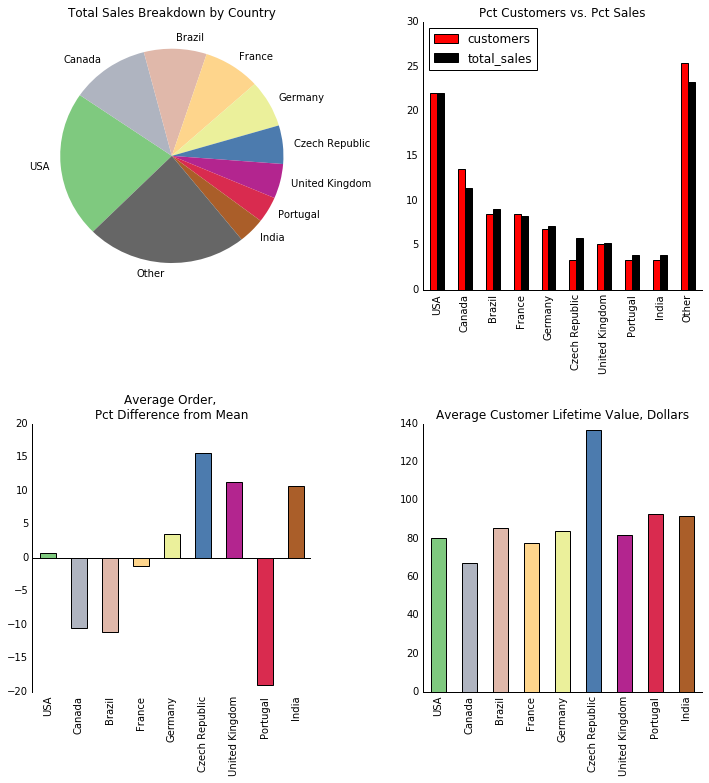

In [8]:
#keep country colors the same
# pie chart for total sales(color)
# average order barchart diff from mean(color)
# avg customer value bar(customer numbers vs. total sales-no color)
# lifetime value bar(color)

country_data = run_query(sales_by_country)
country_data.set_index('country', drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_data.shape[0])]

fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(12,12))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(wspace =.4, hspace = .5)


#top left sales by country
total_sales_metric = country_data['total_sales'].copy().rename('')
total_sales_metric.plot.pie(
    ax = ax1,
    counterclock = False,
    title = 'Total Sales Breakdown by Country',
    fontsize = 10,
    startangle = -135,
    wedgeprops ={'linewidth': 0},
    colormap = plt.cm.Accent
)


#top right comparing % customers vs. % orders
cust_pct_cols = ['customers', 'total_sales']
cust_vs_dols = country_data[cust_pct_cols].copy()
cust_vs_dols.index.name = ''
for col in cust_pct_cols:
    cust_vs_dols[col] /= cust_vs_dols[col].sum() / 100
cust_vs_dols.plot.bar(
    ax = ax2,
    colormap = plt.cm.flag,
    title = 'Pct Customers vs. Pct Sales'
)
ax2.tick_params(top='off', bottom='off', right='off', left='off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#bottom left average order % diff from mean
avg_order_metric = country_data['avg_order'].copy()
#other being dropped as we are looking at variances between countries
#and Other(countries) are all around the world
avg_order_metric.drop('Other', inplace=True)
avg_order_metric.index.name = ''
diff_from_mean = avg_order_metric * 100 / avg_order_metric.mean() - 100
diff_from_mean.plot.bar(
ax = ax3,
color = colors,
title = 'Average Order, \nPct Difference from Mean')
ax3.axhline(0, color = 'black')
ax3.tick_params(top='off', bottom='off', right='off', left='off')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)


#bottom right customer lifetime value
cust_life_val = country_data['avg_customer_value']
#dropping other for same reason as previous plot
cust_life_val.drop('Other', inplace=True)
cust_life_val.index.name = ''
cust_life_val.plot.bar(
ax = ax4,
color = colors,
title = 'Average Customer Lifetime Value, Dollars'
)
ax4.tick_params(top='off', bottom='off', right='off', left='off')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

Based on the above data, there may be opportunities for growth in:
-  Czech republic
-  United Kingdom
-  India

Although there are possibilities for growth in these countries, we must note that the sample size from these countries is extremely low. We should be cautious spending too much money on new campaigns, the amount of data is just too small to give us high confidence. A better idea might be to run smaller campaigns and collect and analyze information from those to be sure the trend holds with new customers.

## Albums vs. Single Tracks

Our Chinook store is set up in a way that two different types of purchases can be made. Currently you can purchase a whole album or purchase a collection of one or more individual songs. In the existing setup you cannot purchase a whole album and then add individual tracks to that same purchase unless each track is selected seperately. Our management is considering a money saving strategy of purchasing only the most popular songs from record companies as opposed to the whole album. Our task is to determine the percentage of whole album vs. individual track purchases.

In this instance we have two different edge cases to consider:

-  Albums that only have one or two tracks that are likely to be purchased by customers as part of a collection of individual tracks.
-  Customers that add every track from an album and then add a few individual tracks from other albums to their purchase.

Our analysis here is to maximize revenue so we can ignore the case of albums containing only a couple of tracks. Our company has done previous work and determined that the second case does not happen often, so we can ignore this case as well.

In [9]:
#function album or not
#then check individual invoices to get percentage

track_or_album = '''
WITH first_song_invoice AS 
    (
    SELECT
        il.invoice_id invoice_id,
        MIN(il.track_id) first_track_id
    FROM invoice_line il
    GROUP BY 1
    )
   
SELECT 
    album_bought,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) * 100 / (
                                        SELECT COUNT (*) FROM invoice
                                        ) percent_of_invoices
FROM
    (
    SELECT 
        fsi.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = fsi.first_track_id
                                    )
                EXCEPT
                
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = fsi.invoice_id
                  ) IS NULL
                AND
                    (
                    SELECT il2.track_id FROM invoice_line il2
                    WHERE il2.invoice_id = fsi.invoice_id
                    
                    EXCEPT
                    
                    SELECT t.track_id FROM track t
                    WHERE t.album_id =(
                                       SELECT t2.album_id FROM track t2
                                       WHERE t2.track_id = fsi.first_track_id
                                       )
                    ) IS NULL
                THEN "yes"
                ELSE "no"
            END AS "album_bought"
        FROM first_song_invoice fsi
    )
GROUP BY album_bought;
'''

run_query(track_or_album)

,album_bought,number_of_invoices,percent_of_invoices
0,no,500,81.433225
1,yes,114,18.566775


In the table above we can see that album purchases account for 18.6% of our revenue. With nearly one fifth of our customner base purchasing in this manner, I would recommend against purchasing only select tracks from albums from record companies as the potential for lost customer base and revenue seems quite high compared to the potential savings. We also need to keep in mind that albums typically contain 6 or more tracks (Apple Music album definition __[here](https://www.abc.net.au/triplej/news/musicnews/what-is-an-album-in-2018/9958448)__).
.
## Most popular artist

Now we will find which artist is used in the most playlists.

In [10]:
most_pop_artist_tracks = '''
SELECT 
    a.name artist_name,
    COUNT(a.name) playlist_count,
    g.name genre
FROM artist a
    INNER JOIN album al ON al.artist_id = a.artist_id
    INNER JOIN track t ON t.album_id = al.album_id
    INNER JOIN genre g ON t.genre_id = g.genre_id
    INNER JOIN playlist_track pt ON pt.track_id = t.track_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 20;
'''
run_query(most_pop_artist_tracks)

,artist_name,playlist_count,genre
0,Iron Maiden,516,Rock
1,U2,333,Pop
2,Metallica,296,Metal
3,Led Zeppelin,252,Rock
4,Deep Purple,226,Rock
5,Lost,184,Drama
6,Pearl Jam,177,Rock
7,Eric Clapton,145,Latin
8,Faith No More,145,Alternative & Punk
9,Lenny Kravitz,143,Metal


We can see above that Iron Maiden is used in the most playlists at almost 6% of the total playlists which isn't too surprising considering they have produced a prodigious 16 studio albums and 39 total albums. We also see once again that the Rock genre occurs far more frequently than any other genre again confirming its popularity in our store.

## Purchased vs. Not Purchased

Now we will look at how many tracks have been purchased vs not purchased.

In [11]:
purchased_vs_not = '''
SELECT 
    COUNT(DISTINCT(pt.track_id)) total_tracks,
    COUNT(DISTINCT(il.track_id)) tracks_sold,
    (COUNT(DISTINCT(pt.track_id)) - 
                                COUNT(DISTINCT(il.track_id))) tracks_not_sold
    FROM playlist_track pt
    LEFT JOIN invoice_line il ON pt.track_id = il.track_id
'''

run_query(purchased_vs_not)

,total_tracks,tracks_sold,tracks_not_sold
0,3503,1806,1697


We can see from the above information that we sell roughly half of the tracks in our store. One idea would be to look into some kind of optimization strategy based on this knowledge in order to reduce our purchaasing costs.

## Tracks in Inventory vs. Sold

As a first step toward that end, we will take a look at the range of tracks we currently have in our store to see if it is reflective of our current sales popularity.

In [12]:
inventory_vs_sold = '''
SELECT 
    g.name genre,
    count(distinct(t.track_id)) tracks_available,
    cast(count(distinct(t.track_id)) AS FLOAT)*100/(SELECT
    count (*) FROM track) percentage_inventory,
    
    count(il.invoice_line_id) tracks_sold,
    cast(count(il.track_id) AS FLOAT)*100/
                                    (SELECT COUNT (*) FROM invoice_line) percentage_sold,
    
    (cast(count(il.track_id) AS FLOAT)*100/
                                    (SELECT COUNT (*) FROM invoice_line)) - 
                                                    (cast(count(distinct(t.track_id)) AS FLOAT)*100
                                                    /(SELECT count (*) FROM track))
                                                    pct_sold_ovr_pct_inv
    
FROM track t
LEFT JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 4 DESC;
'''

run_query(inventory_vs_sold)

,genre,tracks_available,percentage_inventory,tracks_sold,percentage_sold,pct_sold_ovr_pct_inv
0,Rock,1297,37.025407,2635,55.392054,18.366647
1,Metal,374,10.676563,619,13.012403,2.335840
2,Alternative & Punk,332,9.477591,492,10.342653,0.865062
3,Latin,579,16.528690,167,3.510616,-13.018074
4,R&B/Soul,61,1.741365,159,3.342443,1.601078
5,Blues,81,2.312304,124,2.606685,0.294381
6,Jazz,130,3.711105,121,2.543620,-1.167485
7,Alternative,40,1.141878,117,2.459533,1.317655
8,Easy Listening,24,0.685127,74,1.555602,0.870475
9,Pop,48,1.370254,63,1.324364,-0.045890


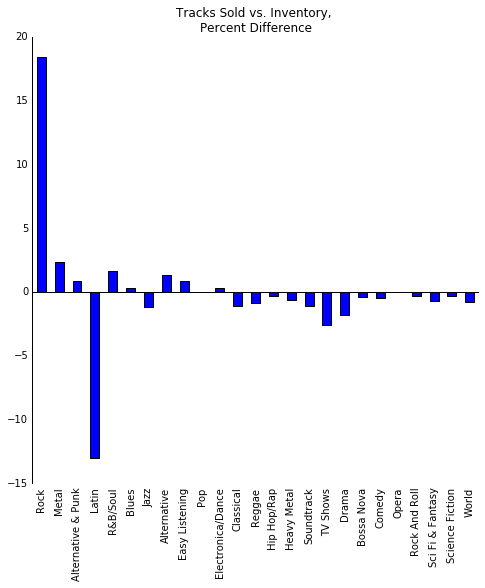

In [13]:
track_inventory_metric = run_query(inventory_vs_sold)
track_inventory_metric.set_index('genre', drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(8,8))

track_inventory_metric.index.name = ''
inv_vs_sold_metric = track_inventory_metric['pct_sold_ovr_pct_inv'] 
inv_vs_sold_metric.plot.bar(
color = 'blue',
title = 'Tracks Sold vs. Inventory, \nPercent Difference')
ax.axhline(0, color = 'black')
ax.tick_params(top='off', bottom='off', right='off', left='off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

Most of our inventory is closely matched with our sales. However, we can see above that there are two opportunities to look into changing our inventory. We have over 16.5% of our inventory in the `Latin` genre, while we only sell 3.5%, representing a possible oversupply. Conversely, we sell over 55% of our tracks in the `Rock` genre while our inventory has only 37% representing a possible undersupply. Getting the inventory of tracks in these two genres more closely aligned to actual sales would be a possible first step in optimizing our inventory and saving on expenses.

## Protected vs. Non-Protected Media

Next we will look at the relative popularity of protected and non-protective media types.

In [14]:
protected_popularity ='''
SELECT 
    mt.name media_type,
    count(distinct(t.track_id)) tracks_available,
    cast(count(distinct(t.track_id)) AS FLOAT)*100/
                                                (SELECT count (*) FROM track) pct_available_by_media,
    
    count(il.invoice_line_id) tracks_sold,
    cast(count(il.track_id) AS FLOAT)*100/
                                        (SELECT COUNT (*) FROM invoice_line) pct_sold_by_media
    
FROM track t
LEFT JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
GROUP BY 1
ORDER BY 2 DESC;
'''
run_query(protected_popularity)

,media_type,tracks_available,pct_available_by_media,tracks_sold,pct_sold_by_media
0,MPEG audio file,3034,86.611476,4259,89.531217
1,Protected AAC audio file,237,6.765629,439,9.228505
2,Protected MPEG-4 video file,214,6.109049,3,0.063065
3,AAC audio file,11,0.314017,21,0.441455
4,Purchased AAC audio file,7,0.199829,35,0.735758


We can see in the above table that there is not a distinct difference between protected media types and non-protected types. One significant observation here is that the video files are not very popular at all. They represent over 6% of files available but are only .06% of sales and only have 3 total sales.